In [1]:
# %install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, MultiPoint
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=False, use_cache=True)
%config IPCompleter.greedy=True
import contextily as ctx
import rasterio

time: 3.17 s (started: 2021-08-15 09:35:49 +02:00)


In [2]:
# in case of encountering problems with GEOS or GDAL, disable speedups from shapely
from shapely import speedups
speedups.disable()

time: 382 µs (started: 2021-08-15 09:35:52 +02:00)


lyon coordinate reference system:  epsg:4326
Projected Lyon coordinate reference system:  +proj=utm +zone=31 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


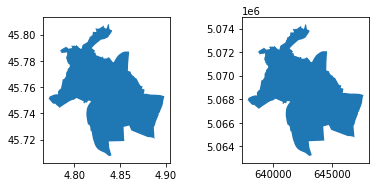

time: 545 ms (started: 2021-08-15 09:35:52 +02:00)


In [3]:
# load Milan city from openstreetmap using osmmnx api

city_name = 'Lyon, France'
city = ox.geocode_to_gdf(city_name)
print('lyon coordinate reference system: ', city.crs)

# project to the local coordinate reference system
city_proj = ox.projection.project_gdf(city)
print('Projected Lyon coordinate reference system: ', city_proj.crs)

fig, (ax1, ax2) = plt.subplots(1, 2)
city.plot(ax=ax1, ec='none')
city_proj.plot(ax=ax2, ec='none' )
plt.tight_layout(pad=3.0)
plt.show()

In [4]:
# convert to "ESRI:54009" coordinate system, since that's the system NASA uses
city = city.to_crs("ESRI:54009") 
print(city.crs)

ESRI:54009
time: 260 ms (started: 2021-08-15 09:35:56 +02:00)


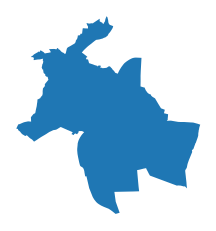

time: 96.7 ms (started: 2021-08-15 09:35:56 +02:00)


In [5]:
# plot city in new projection
ax = city.plot(ec='none')
_ = ax.axis('off')

In [6]:
# save to file
city.to_file('lyon_54009.shp')

time: 94.1 ms (started: 2021-08-15 09:35:58 +02:00)


<ipython-input-6-55cb50a5764a>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  city.to_file('lyon_54009.shp')


In [7]:
# load the saved file
import fiona
with fiona.open("lyon_54009.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

time: 193 ms (started: 2021-08-15 09:36:00 +02:00)


In [8]:
# load the NASA population density raster file
# Data source: https://sedac.ciesin.columbia.edu/data/collection/gpw-v4
import rasterio.mask
with rasterio.open("data/GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0/GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0.tif") as src:
    # since the NASA data is for the entire world, we will use the 'shapes' polygon containing our city to mask out
    # the population raster data corresponding to our city
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True, nodata=0)
    out_meta = src.meta

time: 196 ms (started: 2021-08-15 09:36:02 +02:00)


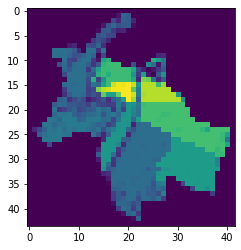

time: 115 ms (started: 2021-08-15 09:36:03 +02:00)


In [9]:
# plot city population 
plt.imshow(out_image[0,:,:])
plt.show()

In [10]:

# since the raster array contains many dimensions, we assign the dimension containing the population density data to a new 
# variable
pop_density = out_image[0,:,:]
pop_density.shape

(44, 42)

time: 2.14 ms (started: 2021-08-15 09:36:05 +02:00)


In [11]:
# just in case, set all negative values to zero
pop_density[pop_density < 0] = 0

time: 500 µs (started: 2021-08-15 09:36:06 +02:00)


In [12]:
# split city into 400 x 400 meter grid cells
geometry = city_proj['geometry'].iloc[0]
print(type(geometry))
geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width = 400)
print(type(geometry_cut))

<class 'shapely.geometry.polygon.Polygon'>
<class 'shapely.geometry.multipolygon.MultiPolygon'>
time: 1.35 s (started: 2021-08-15 09:36:08 +02:00)


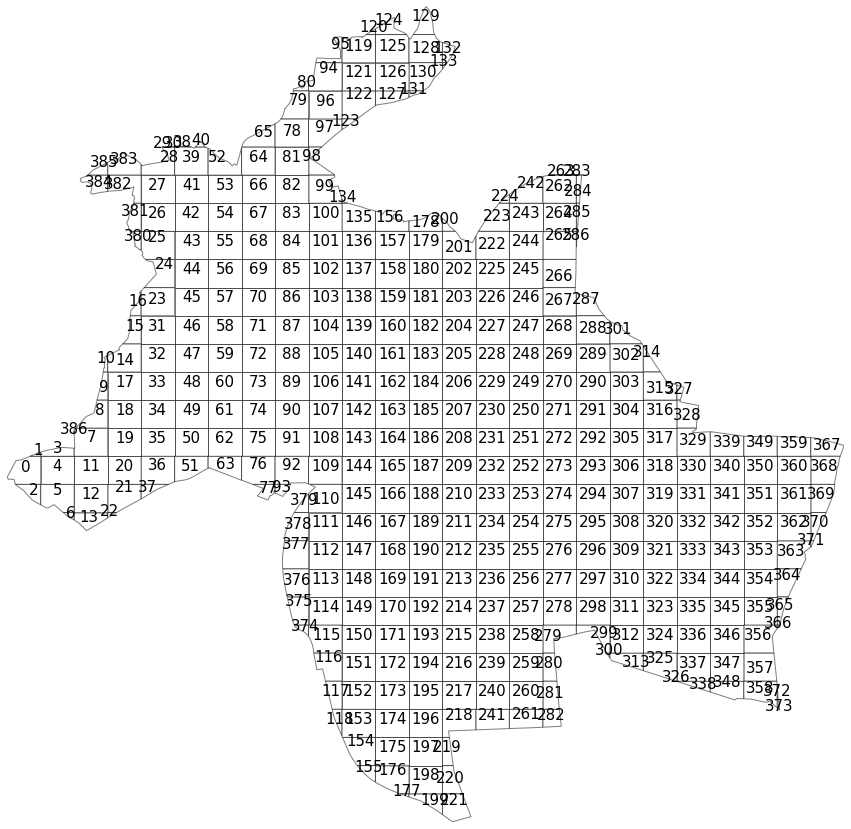

time: 1.92 s (started: 2021-08-18 09:57:35 +02:00)


In [123]:
polylist = [p for p in geometry_cut]

# plot city
west, south, east, north = city_proj.unary_union.bounds

fig, ax = plt.subplots(figsize=(15,15))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    plt.annotate(text=n, xy=p, horizontalalignment='center', size=15)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [14]:
# create geodataframe from the square grid polygons
polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city_proj.crs
print(polyframe.crs)
polyframe.head()

+proj=utm +zone=31 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


geometry
0  POLYGON ((637809.092 5067912.912, 637814.086 5...
1  POLYGON ((638077.995 5068201.460, 638124.717 5...
2  POLYGON ((638202.648 5067814.963, 638202.648 5...
3  POLYGON ((638202.648 5068259.180, 638221.852 5...
4  POLYGON ((638596.204 5068201.460, 638596.204 5...

time: 31.9 ms (started: 2021-08-15 09:36:16 +02:00)


<AxesSubplot:>

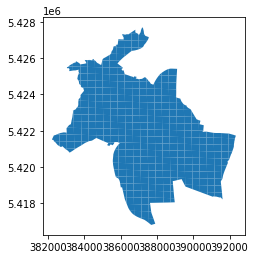

time: 397 ms (started: 2021-08-15 09:36:18 +02:00)


In [15]:
# convert to the NASA crs we introduced earlier
polyframe= polyframe.to_crs(city.crs)
polyframe.plot()

In [16]:
# load library for aggregating raster data into vector polygons
from rasterstats import zonal_stats

time: 253 ms (started: 2021-08-15 09:36:20 +02:00)


In [125]:
# compute the mean value of all raster values that fall into a given quadratic cell

affine = out_transform
city_stats = zonal_stats(polyframe, pop_density, affine=affine, stats='mean', nodata=0)
pop_array = np.array([list(item.values())[0] if list(item.values())[0] is not None else 0 for item in city_stats])


time: 590 ms (started: 2021-08-18 13:23:54 +02:00)


In [18]:
city_stats[:10]

[{'mean': 165.1400604248047},
 {'mean': None},
 {'mean': 426.2760925292969},
 {'mean': 553.9335327148438},
 {'mean': 381.8072509765625},
 {'mean': 557.3243408203125},
 {'mean': None},
 {'mean': 537.8413467407227},
 {'mean': 481.9497985839844},
 {'mean': 486.7471466064453}]

time: 2.99 ms (started: 2021-08-15 09:36:26 +02:00)


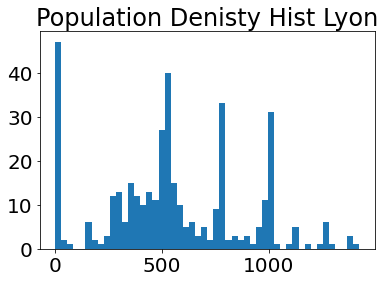

time: 281 ms (started: 2021-08-18 09:49:07 +02:00)


In [119]:
# plot histogram of the obtained population density values
plt.hist(pop_array, bins=50)
plt.title("Population Denisty Hist Lyon")
plt.show()

In [20]:
# assign the population values as a new column in the geodataframe with the grid cells, 
# so we know which grid cell has what population.

polyframe["population"] = pop_array
polyframe.head()

geometry  population
0  POLYGON ((382217.397 5421522.187, 382222.350 5...  165.140060
1  POLYGON ((382489.831 5421796.626, 382537.608 5...    0.000000
2  POLYGON ((382624.393 5421418.580, 382628.845 5...  426.276093
3  POLYGON ((382617.333 5421849.992, 382636.999 5...  553.933533
4  POLYGON ((383023.696 5421785.430, 383029.830 5...  381.807251

time: 30.5 ms (started: 2021-08-15 09:36:40 +02:00)


(256, 4)
[[1.         0.96078431 0.94117647 1.        ]
 [0.99987697 0.95820069 0.93748558 1.        ]
 [0.99975394 0.95561707 0.93379469 1.        ]
 ...
 [0.41917724 0.00369089 0.05294887 1.        ]
 [0.4115494  0.00184544 0.05196463 1.        ]
 [0.40392157 0.         0.05098039 1.        ]]


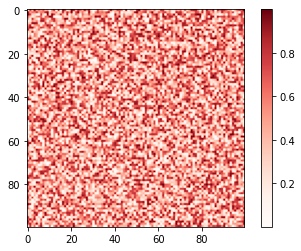

time: 193 ms (started: 2021-08-15 09:36:44 +02:00)


In [21]:
# in order to achieve a nice-looking visualisation, let's create a custom colormap, that fades away into transparency

ncolors = 256
# get cmap
color_array = plt.get_cmap('Reds')(range(ncolors))
print(color_array.shape)
print(color_array)

# change alpha values
color_array[:, -1] = np.linspace(0.3, 1, ncolors)

# create colormap object
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

map_object = LinearSegmentedColormap.from_list(name="Reds_transp", colors=color_array)

# register the colormap object
plt.register_cmap(cmap=map_object)

# plot some example data
fig, ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100), cmap='Reds_transp')
plt.colorbar(mappable=h)

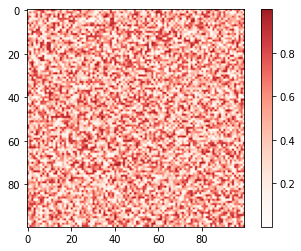

time: 205 ms (started: 2021-08-15 09:36:45 +02:00)


In [22]:
# let's cut it at the top for a better visual impact

def trunc_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list('trunc({n}, {a:.2f}, {b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                                                cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Reds_transp')
new_cmap = trunc_colormap(cmap, 0.0, .9)

# plot some example data
fig, ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100), cmap=new_cmap)
plt.colorbar(mappable=h)

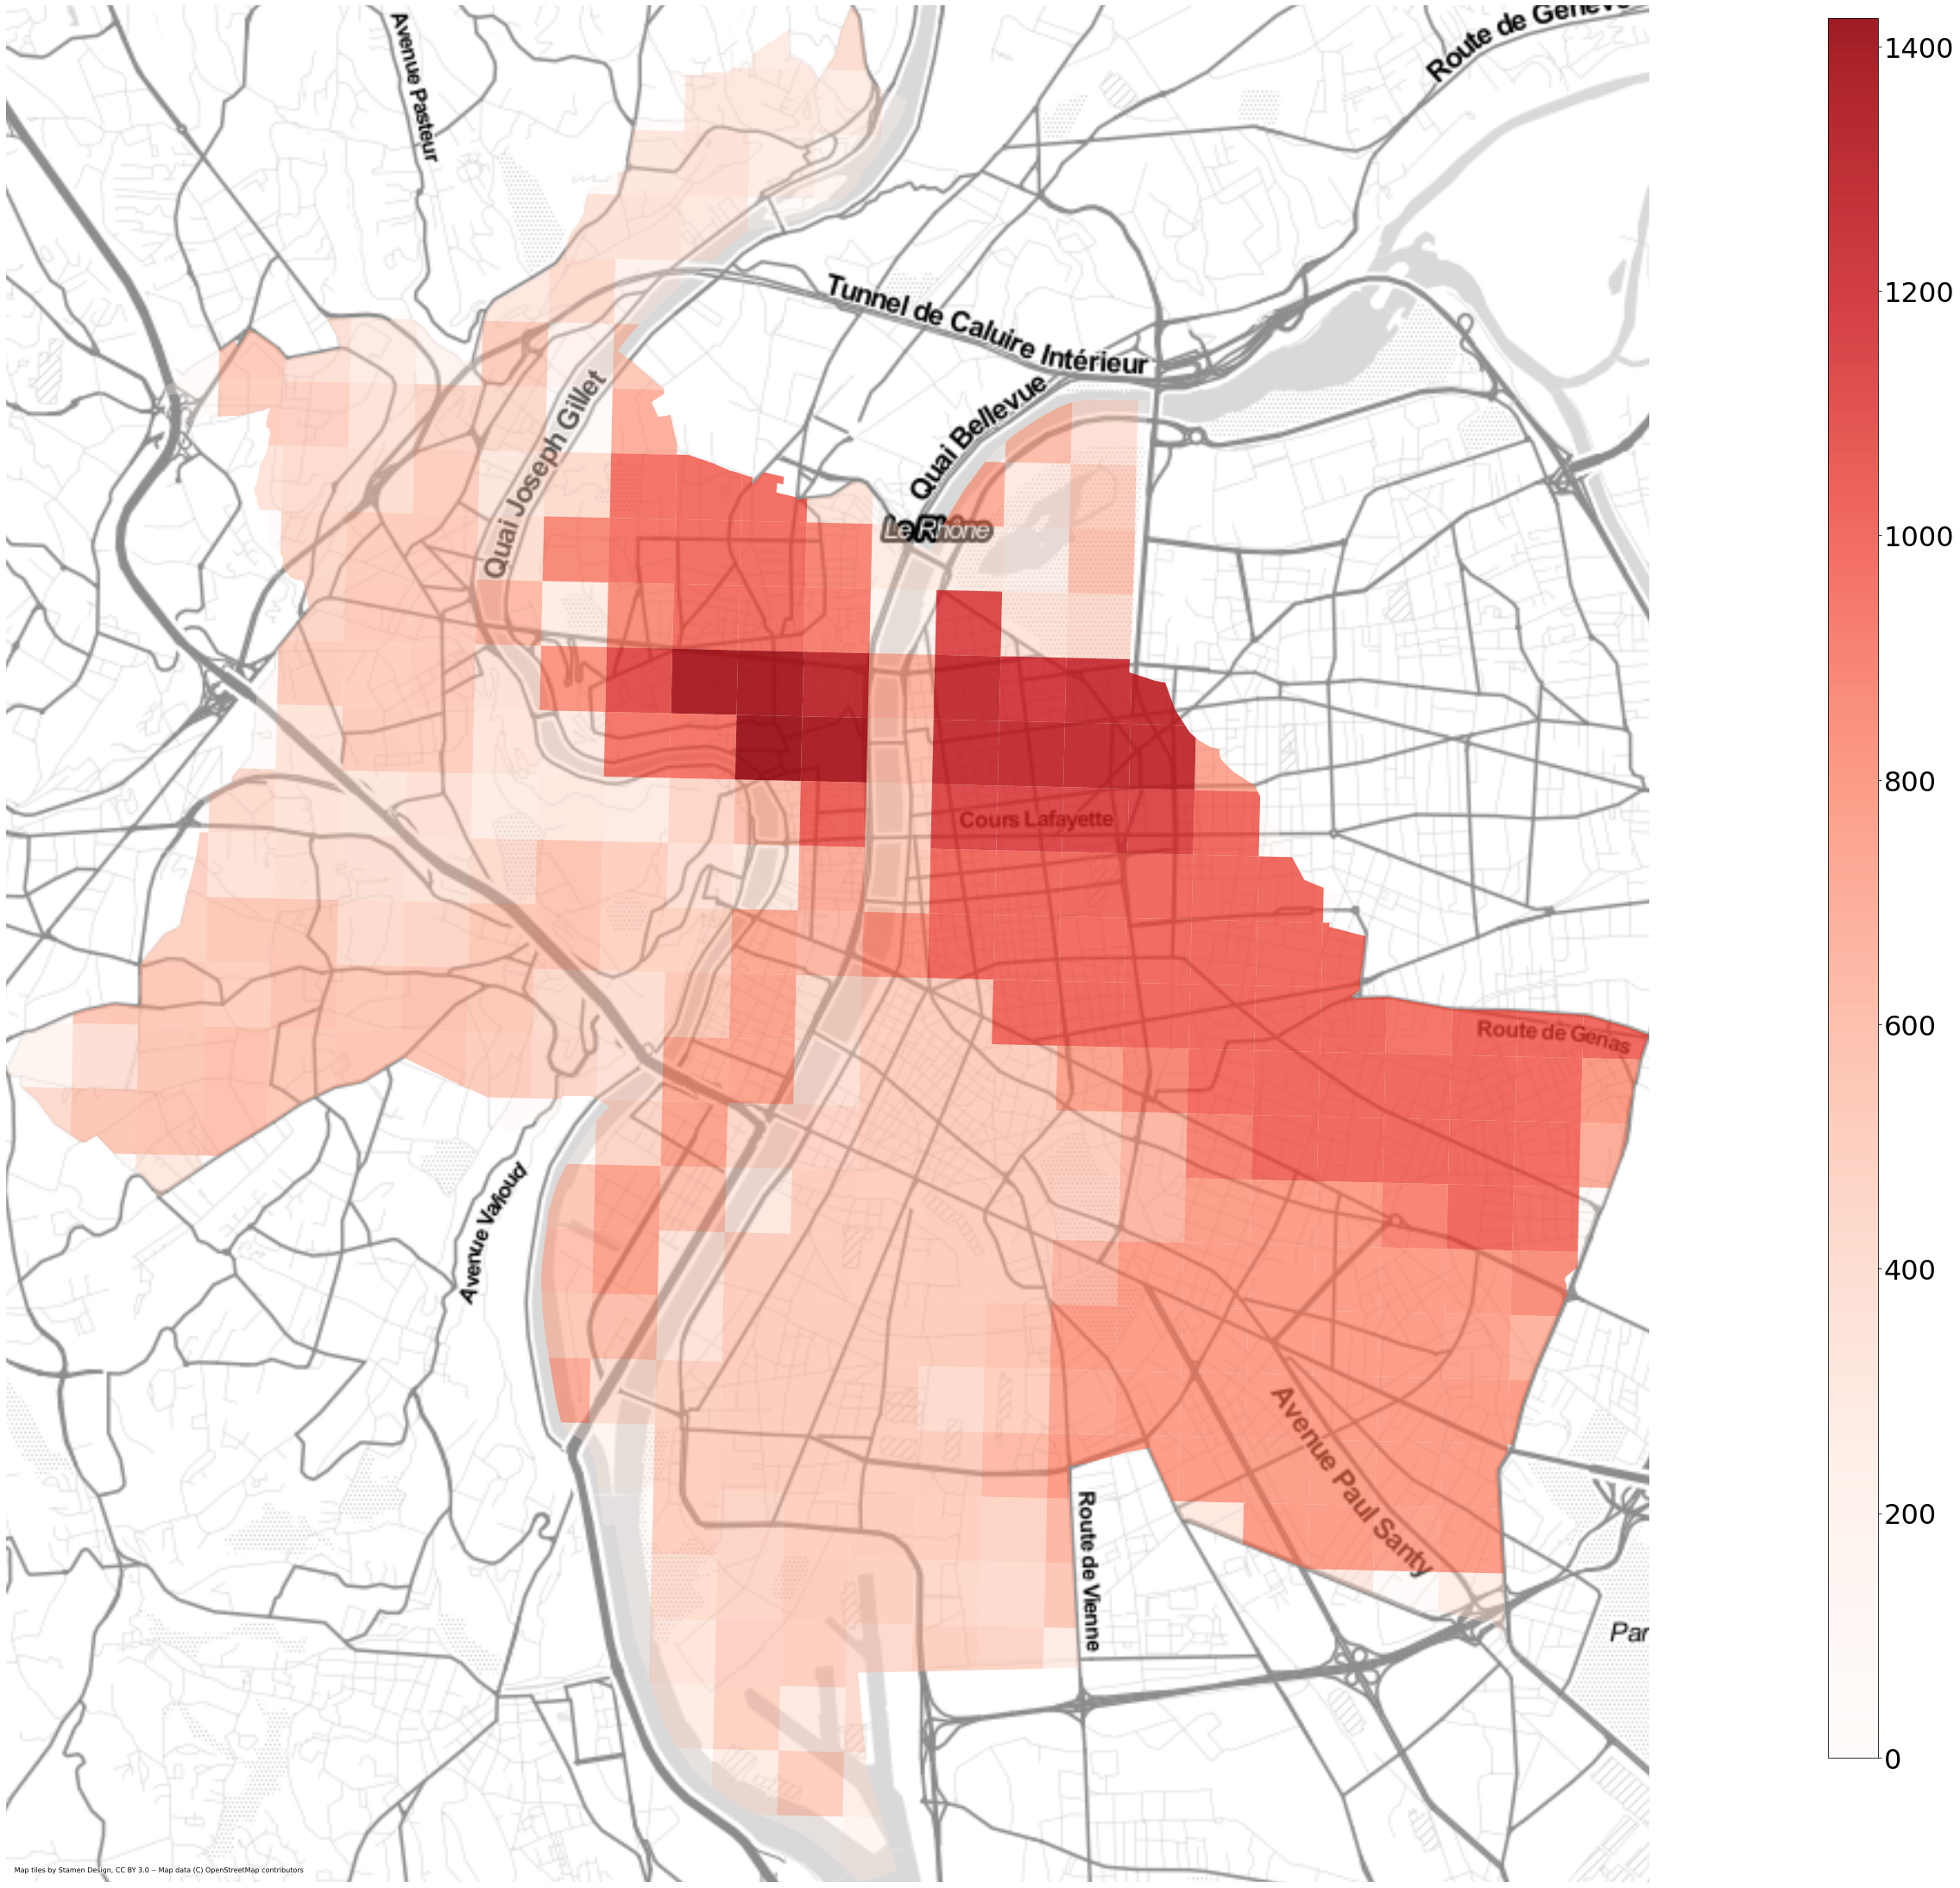

time: 4 s (started: 2021-08-15 09:36:47 +02:00)


In [23]:
# plot the population density data on a map background
plt.rcParams.update({'font.size':32})
import contextily as ctx
# ctx uses epsg:3857
polyframe_3857 = polyframe.to_crs(epsg=3857)
west, south, east, north = polyframe_3857.unary_union.bounds

#ax = polyframe_3857.plot(figsize=(40,40), alpha=0.5, edgecolor='k')
fig, ax = plt.subplots(figsize=(40,40))
polyframe_3857.plot(ax=ax, column = 'population', legend=False, cmap=new_cmap)

cbax = fig.add_axes([0.915, 0.175, 0.02, 0.7])

sm = plt.cm.ScalarMappable(cmap=new_cmap, \
                          norm = plt.Normalize(vmin=min(polyframe_3857.population), vmax=max(polyframe_3857.population)))

sm._A = []

# draw colormap into cbax

fig.colorbar(sm, cax=cbax, format="%d")

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, zoom=13)
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

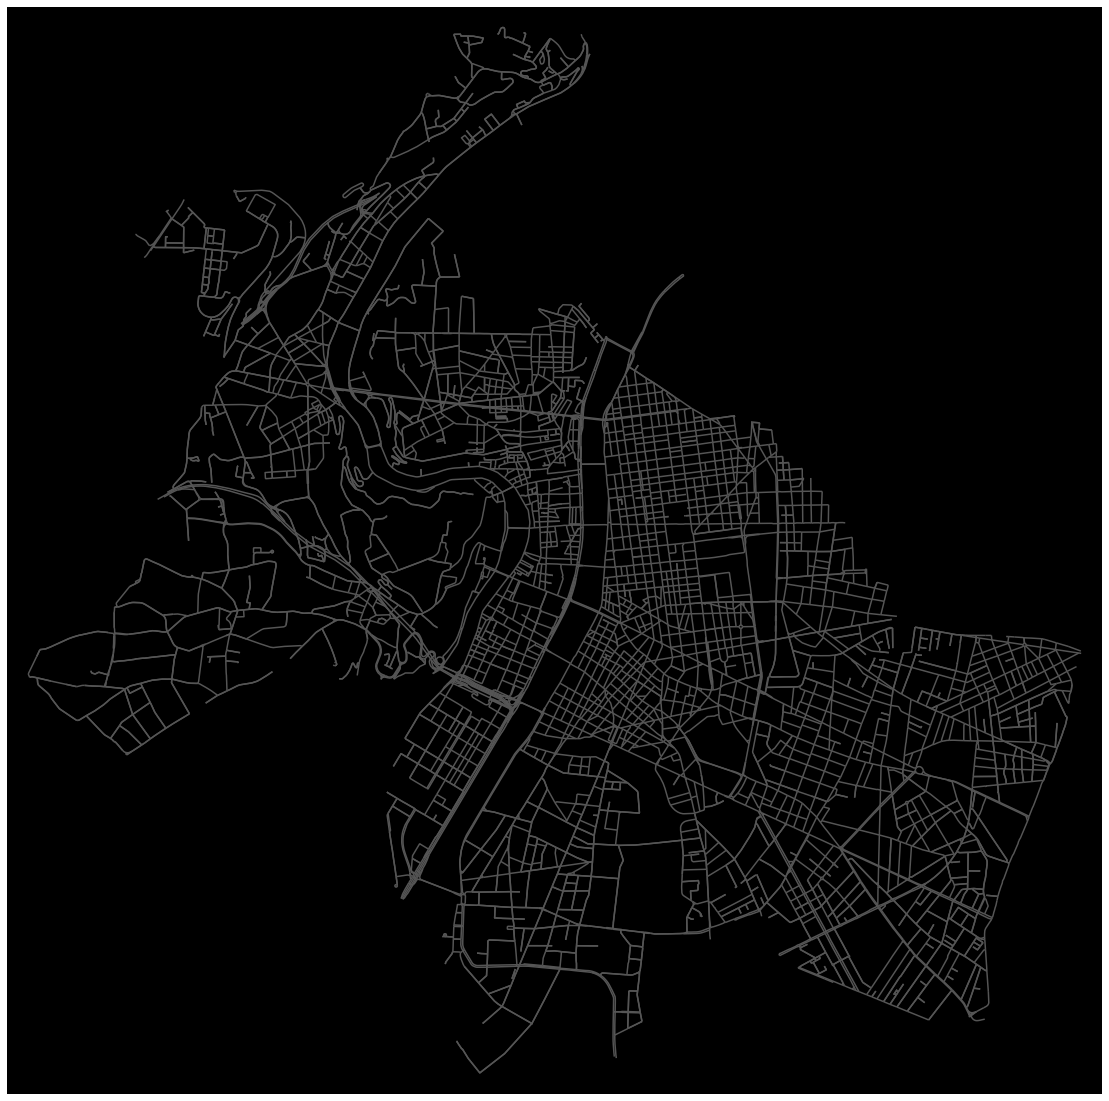

time: 9.92 s (started: 2021-08-15 09:37:08 +02:00)


In [24]:
# download and project a street network
G = ox.graph_from_place(city_name, network_type="drive")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, figsize=(20,20), bgcolor='k', node_size=0, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1)

In [25]:
# set new coordinate reference system
from pyproj import CRS
crs = CRS.from_epsg(4326)
polyframe_gps = polyframe.to_crs(crs)
print(polyframe_gps.crs)

epsg:4326
time: 246 ms (started: 2021-08-15 09:38:33 +02:00)


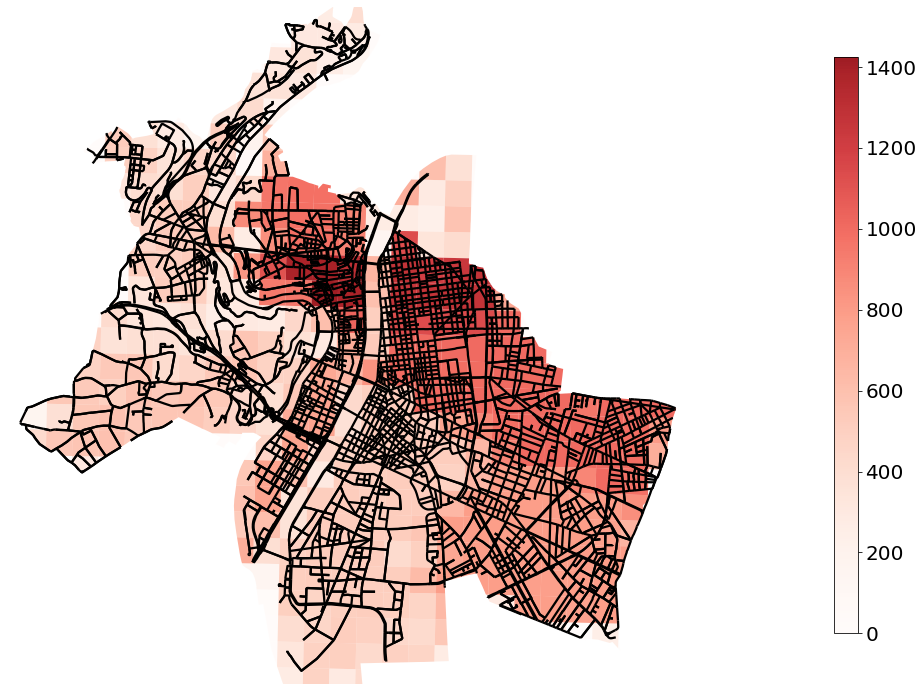

time: 3.11 s (started: 2021-08-19 10:01:04 +02:00)


In [127]:
fig, ax = plt.subplots(figsize=(15,10))

#plt.close()
polyframe_gps.plot(ax=ax, column = 'population', legend=False, cmap=new_cmap)

ox.plot_graph(G, ax=ax, figsize=(40,40),show=False, close=False, \
              node_color='grey', node_size=0, edge_linewidth=2.25, node_alpha=0.8, node_zorder=10, edge_color='black')

cbax = fig.add_axes([0.95, 0.1, 0.0225, 0.8])

sm = plt.cm.ScalarMappable(cmap=new_cmap, \
                          norm = plt.Normalize(vmin=min(polyframe_gps.population), vmax=max(polyframe_gps.population)))

sm._A = []

# draw colormap into cbax

fig.colorbar(sm, cax=cbax, format="%d")

ax.axis('off')
plt.tight_layout()
#plt.savefig('../data/Milan_pop_density_with_streets.jpg', dpi=150)
plt.show()

In [28]:
# let's get a list containing the street network node IDs
graph = G.nodes(data=True)
nodelist = [x[0] for x in graph]
nodelist[:10]

[143403,
 143408,
 143412,
 143413,
 143415,
 143416,
 143417,
 143418,
 143421,
 143435]

time: 3.42 ms (started: 2021-08-15 09:38:43 +02:00)


In [29]:
# then, we create a dataframe containing features of the street nodes (junctions)
from tqdm import tqdm
street_dict = {'osmid':[], 'lon':[], 'lat':[], 'street_count':[]}
for node in tqdm(nodelist):
    street_dict['osmid'].append(node)
    street_dict['lon'].append(graph[node]['x'])
    street_dict['lat'].append(graph[node]['y'])
    street_dict['street_count'].append(graph[node]['street_count'])
    
street_frame = pd.DataFrame(street_dict)
street_frame['street_count'].max()

100%|██████████| 4273/4273 [00:00<00:00, 289732.31it/s]


8

time: 61.3 ms (started: 2021-08-15 09:38:49 +02:00)


In [30]:
# let's create Point geometries from the lat, lon pairs. 
geometry = [Point(xy) for xy in zip(street_frame.lon, street_frame.lat)]
street_frame = street_frame.drop(['lon', 'lat'], axis=1)
gdf = gpd.GeoDataFrame(street_frame, crs=crs, geometry=geometry)
gdf.tail()

osmid  street_count                  geometry
4268  8913421864             3  POINT (4.87031 45.72736)
4269  8913425919             4  POINT (4.86931 45.72700)
4270  8913425921             4  POINT (4.86953 45.72707)
4271  8913468465             4  POINT (4.87123 45.72451)
4272  8913468466             4  POINT (4.87160 45.72441)

time: 129 ms (started: 2021-08-15 09:38:52 +02:00)


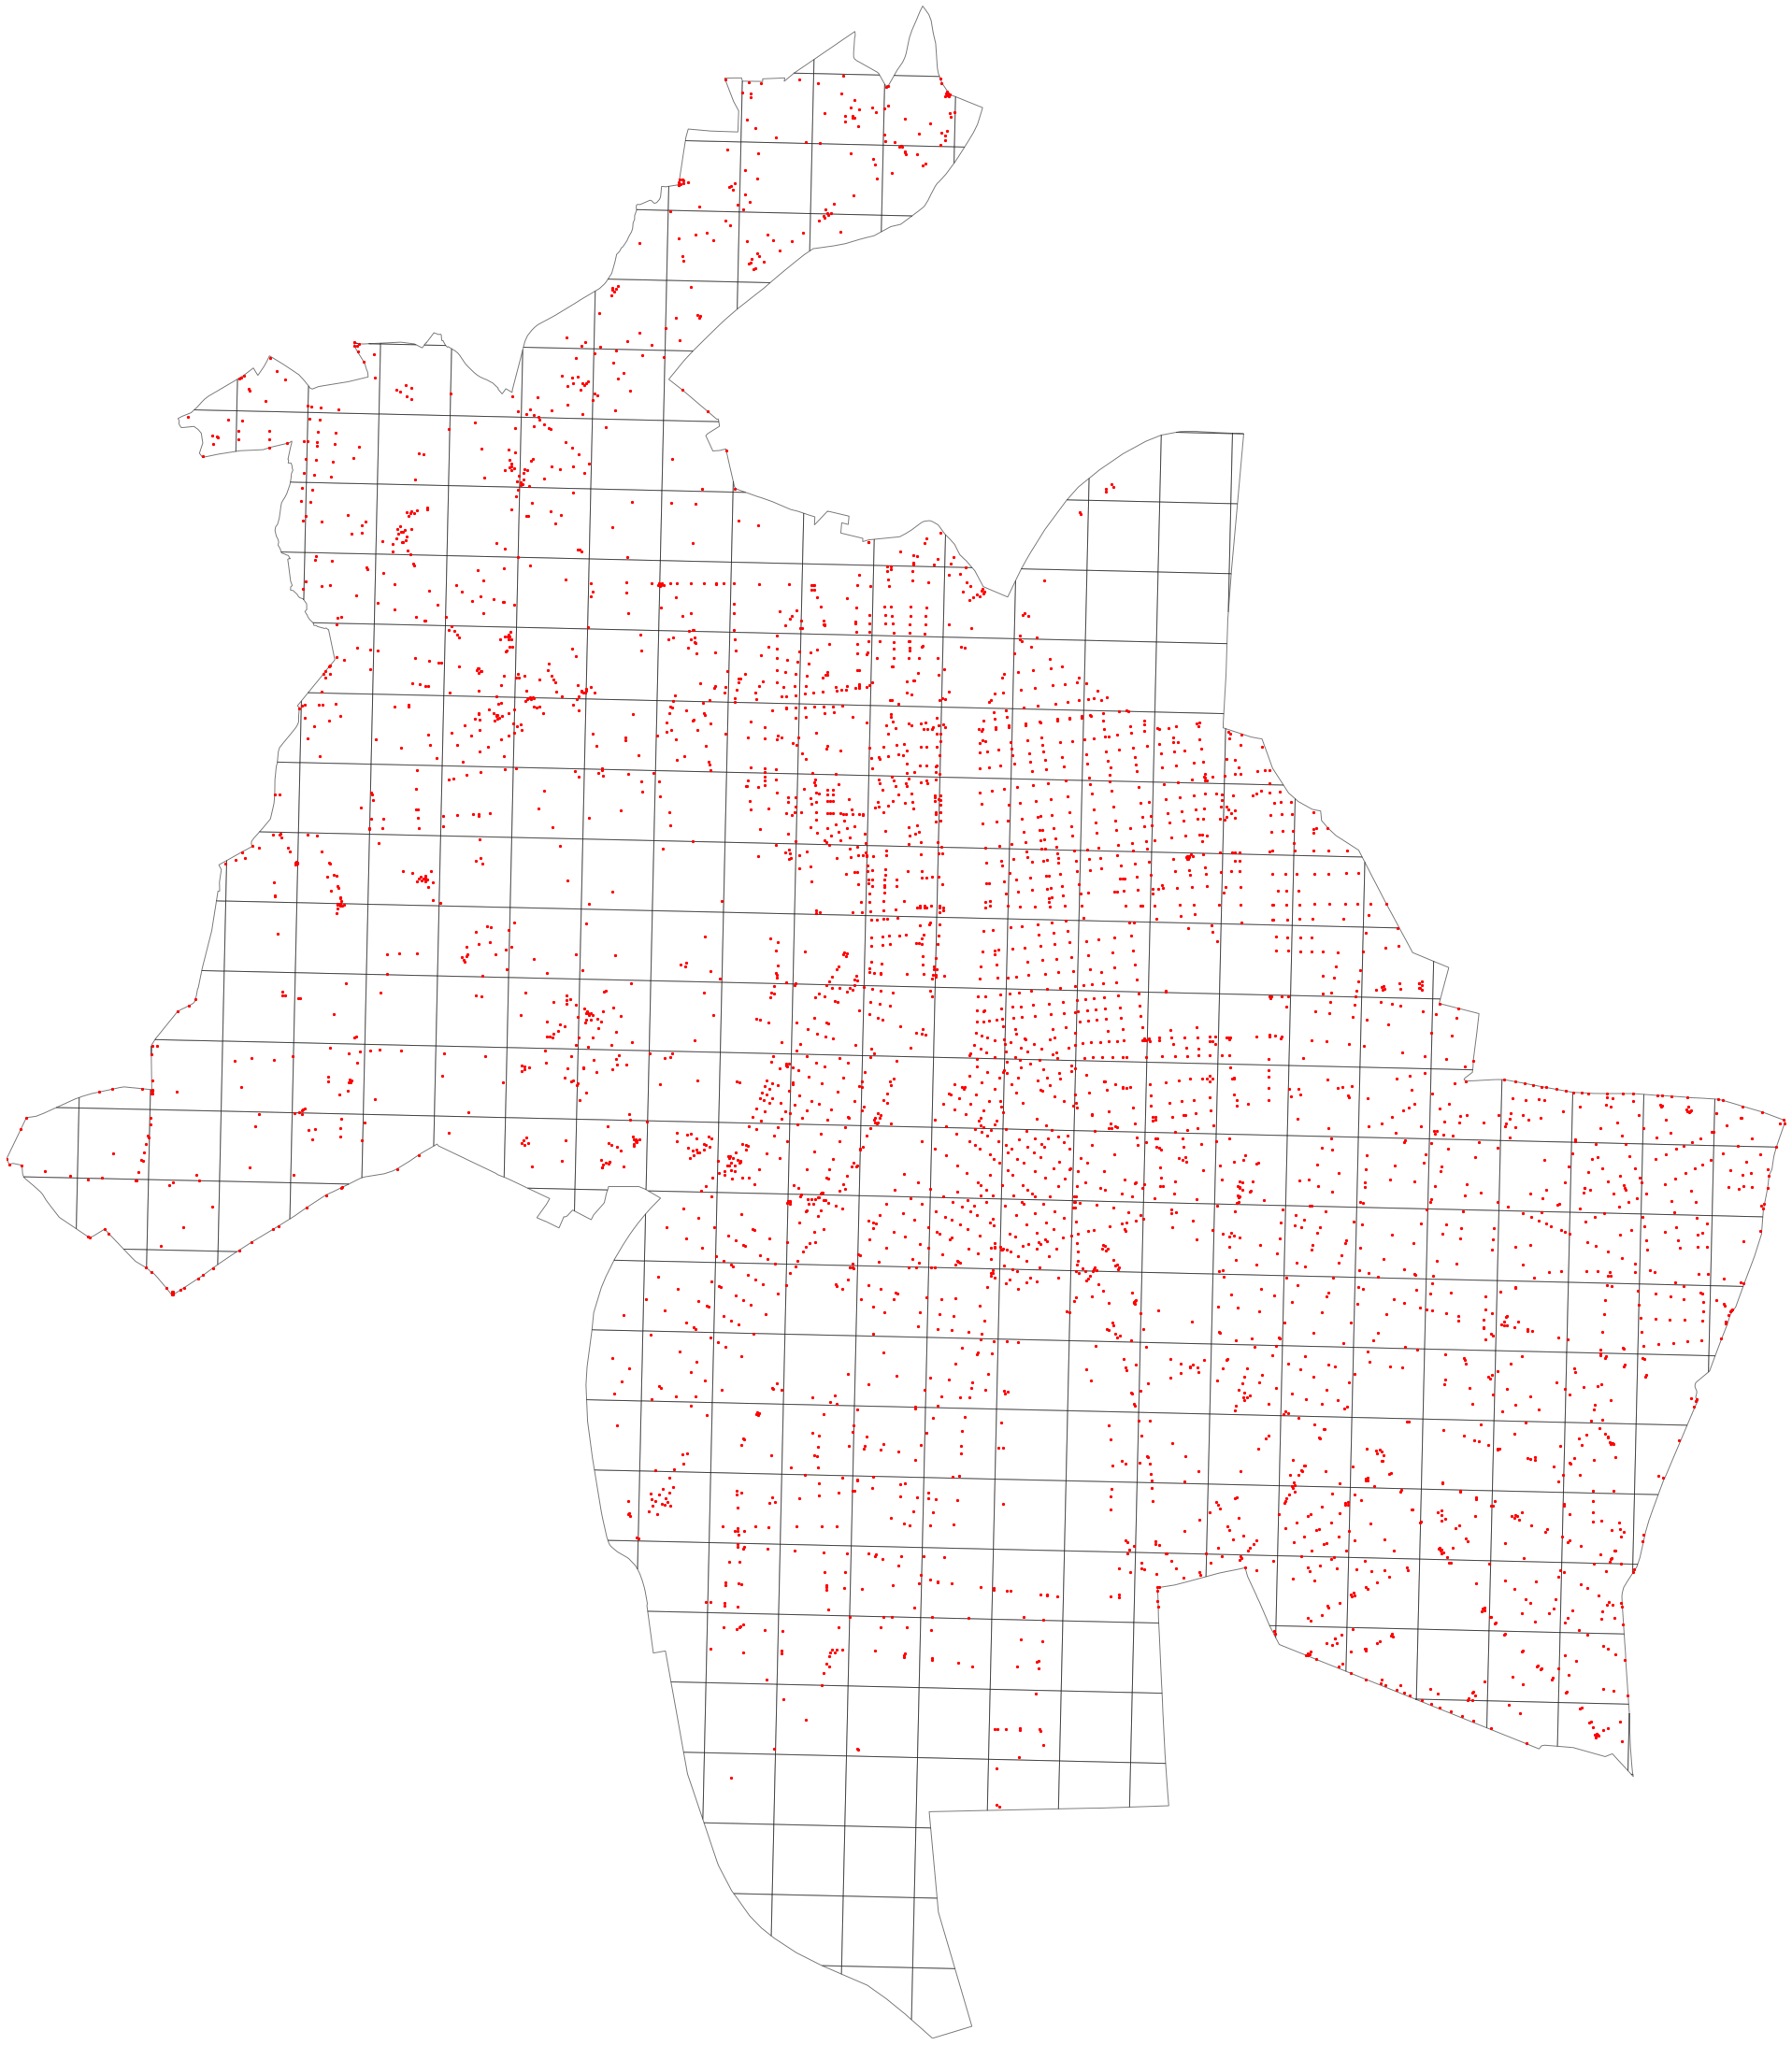

time: 1.23 s (started: 2021-08-15 09:38:56 +02:00)


In [31]:
west, south, east, north = polyframe_gps.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,40))
for polygon, n in zip(polyframe_gps.geometry, np.arange(len(polyframe_gps))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)
gdf.plot(ax=ax, color='red', markersize=5, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [32]:
#do a group by and get all the street counts in the polygon, sum them.
pointInPoly = gpd.sjoin(polyframe_gps, gdf, op='contains')
print(len(pointInPoly))
pointInPoly.head(10)

4234


geometry  population  index_right  \
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...  165.140060         3443   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...  165.140060         3279   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...  165.140060         3759   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...  165.140060           86   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...  165.140060         3781   
3  POLYGON ((4.77697 45.75407, 4.77722 45.75413, ...  553.933533         3507   
3  POLYGON ((4.77697 45.75407, 4.77722 45.75413, ...  553.933533         3375   
4  POLYGON ((4.78201 45.75347, 4.78190 45.75000, ...  381.807251         3444   
4  POLYGON ((4.78201 45.75347, 4.78190 45.75000, ...  381.807251         3348   
4  POLYGON ((4.78201 45.75347, 4.78190 45.75000, ...  381.807251         3349   

        osmid  street_count  
0  1847333006             2  
0  1385683132             2  
0  3302688255             3  
0     8565540             4  
0  3601912860             2  
3  2091550546             3  
3  1577020317             3  
4  1849618740             2  
4  1547919220             3  
4  1547919223             1

time: 308 ms (started: 2021-08-15 09:39:05 +02:00)


In [33]:
streetcounts = pointInPoly.groupby(pointInPoly.index)['index_right'].count()
counts = pd.DataFrame(streetcounts)
counts.columns = ['counts']
counts

counts
0         5
3         2
4         9
5         7
6         1
..      ...
380       1
381       4
382      10
383      10
384       7

[324 rows x 1 columns]

time: 7.76 ms (started: 2021-08-15 09:39:17 +02:00)


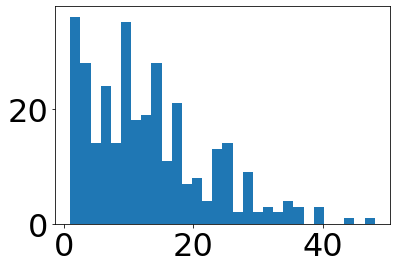

time: 109 ms (started: 2021-08-15 09:39:21 +02:00)


In [34]:
# a quick histogram of the street node counts
plt.hist(counts.counts, bins=30)
plt.show()


In [35]:
polycounts = polyframe_gps.copy()
polycounts['counts'] = counts.counts
polycounts['counts'].fillna(0, inplace=True)
polycounts['counts'] = polycounts['counts'].astype(int)
polycounts

geometry  population  counts
0    POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...  165.140060       5
1    POLYGON ((4.77535 45.75358, 4.77596 45.75377, ...    0.000000       0
2    POLYGON ((4.77684 45.75007, 4.77676 45.74755, ...  426.276093       0
3    POLYGON ((4.77697 45.75407, 4.77722 45.75413, ...  553.933533       2
4    POLYGON ((4.78201 45.75347, 4.78190 45.75000, ...  381.807251       9
..                                                 ...         ...     ...
382  POLYGON ((4.79199 45.78463, 4.79203 45.78478, ...  505.787277      10
383  POLYGON ((4.78818 45.78816, 4.78823 45.78974, ...  525.831970      10
384  POLYGON ((4.78812 45.78615, 4.78688 45.78601, ...    0.000000       7
385  POLYGON ((4.78515 45.78821, 4.78534 45.78833, ...    0.000000       0
386  POLYGON ((4.78210 45.75620, 4.78209 45.75653, ...    0.000000       0

[387 rows x 3 columns]

time: 109 ms (started: 2021-08-15 09:39:25 +02:00)


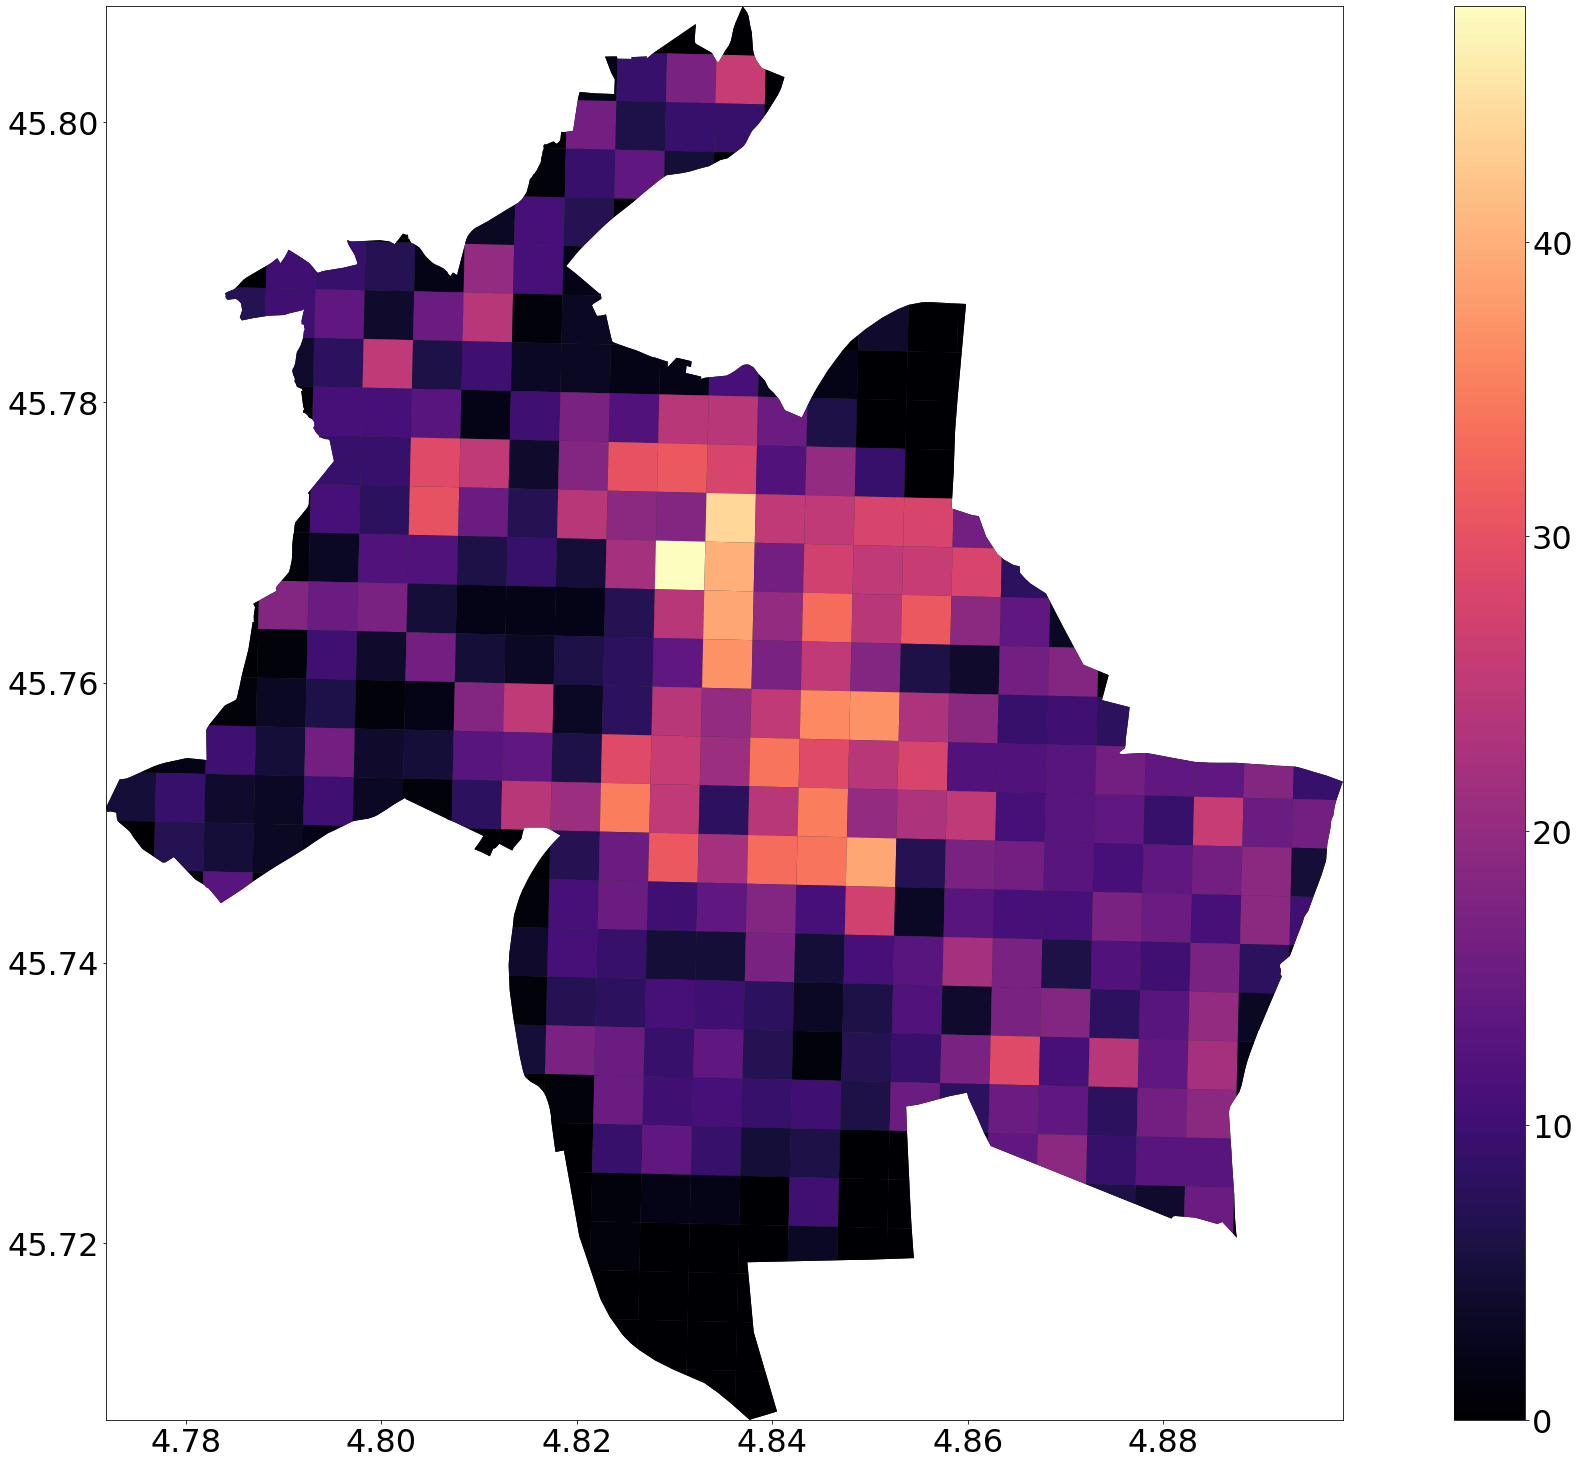

time: 552 ms (started: 2021-08-15 09:39:28 +02:00)


In [36]:
# plot the city street network density
west, south, east, north = polycounts.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe_gps.plot(ax=ax, color='#000004')
polycounts.plot(column='counts',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

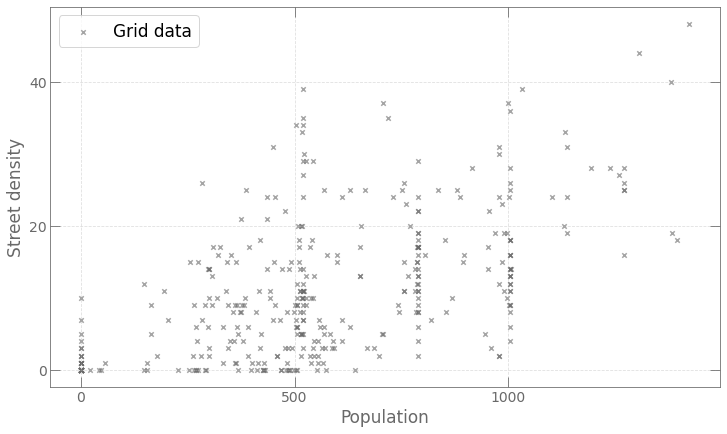

time: 134 ms (started: 2021-08-15 09:39:37 +02:00)


In [37]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(polycounts.population, polycounts.counts, alpha=0.6, color='dimgrey',\
           zorder=1, marker='x', label = "Grid data", s=20)

ax.legend(prop={'size': 17})
plt.xlabel('Population', size=17, color='dimgrey')
plt.ylabel('Street density', size=17, color='dimgrey', rotation=90)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction="in", size=10)
ax.spines['bottom'].set_color('dimgrey')
ax.spines['top'].set_color('dimgrey') 
ax.spines['right'].set_color('dimgrey')
ax.spines['left'].set_color('dimgrey')
ax.tick_params(axis='x', colors='dimgrey')
ax.tick_params(axis='y', colors='dimgrey')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.grid(alpha=0.4,ls='--')
# plt.savefig('pop_dens_milan.jpg', dpi=120)
plt.show()

In [38]:
np.corrcoef(polycounts.population, polycounts.counts)[0, 1]

0.6010578377678888

time: 2.43 ms (started: 2021-08-15 09:39:40 +02:00)


In [39]:
import pandana

time: 13.9 ms (started: 2021-08-15 09:39:41 +02:00)


In [40]:
from pandana.loaders import osm

import warnings
warnings.filterwarnings('ignore')

time: 6.9 ms (started: 2021-08-15 09:39:42 +02:00)


In [41]:
# get bounding box of city first
west, south, east, north = polycounts.unary_union.bounds
print(west, south, east, north)

4.771813400000001 45.70736659999998 4.8983774 45.80826279999999
time: 62.6 ms (started: 2021-08-15 09:39:44 +02:00)


In [42]:
network = osm.pdna_network_from_bbox(south, west, north, east)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](45.70736660,4.77181340,45.80826280,4.89837740);>;);out;'}"
Downloaded 22,277.7KB from www.overpass-api.de in 2.81 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 3.27 seconds
Returning OSM data with 131,358 nodes and 31,512 ways...
Edge node pairs completed. Took 27.22 seconds
Returning processed graph with 41,124 nodes and 58,973 edges...
Completed OSM data download and Pandana node and edge table creation in 32.86 seconds
time: 35.4 s (started: 2021-08-15 09:39:51 +02:00)


In [43]:
network.nodes_df.head()

x          y
id                         
126079  4.820423  45.752337
126096  4.783862  45.789279
143356  4.843250  45.714458
143360  4.863275  45.717665
143365  4.893809  45.724187

time: 5.69 ms (started: 2021-08-15 09:50:20 +02:00)


In [44]:
network.edges_df.head()

from          to     distance
126079 3161283297  126079  3161283297   299.241210
126096 6161708986  126096  6161708986  1082.432150
143356 34676651    143356    34676651   329.391065
       173030999   143356   173030999   147.670783
143360 60078605    143360    60078605   313.031916

time: 6.25 ms (started: 2021-08-15 09:50:23 +02:00)


In [45]:
restaurants = osm.node_query(
    south, west, north, east, tags='"amenity"="restaurant"')

time: 1.11 s (started: 2021-08-15 09:50:25 +02:00)


In [46]:
restaurants.head()

lat       lon     amenity                      name  \
id                                                                    
25733700  45.741033  4.868941  restaurant           L'Esprit Bistro   
26641424  45.756985  4.834612  restaurant  Comptoir des Marronniers   
33065934  45.739344  4.773275  restaurant      Auberge de la Vallée   
47770405  45.766041  4.833507  restaurant              Léon de Lyon   
73657010  45.744413  4.784209  restaurant   Restaurant de la Plaine   

            ref:FR:SIRET                                   contact:facebook  \
id                                                                            
25733700  53178387600034                                                NaN   
26641424  53801942300028  https://www.facebook.com/LeComptoirDesMarronni...   
33065934             NaN                                                NaN   
47770405  97250471600010                                                NaN   
73657010             NaN                                                NaN   

                                       email opening_hours:covid19  \
id                                                                   
25733700                                 NaN                   NaN   
26641424  lecomptoirdesmarronniers@gmail.com                   off   
33065934                                 NaN                   NaN   
47770405                                 NaN                  open   
73657010                                 NaN                   NaN   

                      phone                              website  ...  \
id                                                                ...   
25733700                NaN                                  NaN  ...   
26641424  +33 4 72 77 10 00  http://lecomptoirdesmarronniers.fr/  ...   
33065934                NaN                                  NaN  ...   
47770405  +33 4 72 10 11 12                                  NaN  ...   
73657010                NaN                                  NaN  ...   

         drink:beer drink diet:fresh diet:local takeaway:website  \
id                                                                 
25733700        NaN   NaN        NaN        NaN              NaN   
26641424        NaN   NaN        NaN        NaN              NaN   
33065934        NaN   NaN        NaN        NaN              NaN   
47770405        NaN   NaN        NaN        NaN              NaN   
73657010        NaN   NaN        NaN        NaN              NaN   

         diet:vegetarian:description diet:non-vegetarian network office  \
id                                                                        
25733700                         NaN                 NaN     NaN    NaN   
26641424                         NaN                 NaN     NaN    NaN   
33065934                         NaN                 NaN     NaN    NaN   
47770405                         NaN                 NaN     NaN    NaN   
73657010                         NaN                 NaN     NaN    NaN   

         official_name  
id                      
25733700           NaN  
26641424           NaN  
33065934           NaN  
47770405           NaN  
73657010           NaN  

[5 rows x 151 columns]

time: 20.5 ms (started: 2021-08-15 09:50:27 +02:00)


In [47]:
restaurant_nodes = network.get_node_ids(restaurants.lon, restaurants.lat)
network.set(restaurant_nodes, 
            name = 'restaurants')

time: 20.3 ms (started: 2021-08-15 09:50:30 +02:00)


In [48]:
accessibility = network.aggregate(distance = 500,
                                  type = 'count',
                                  name = 'restaurants')
accessibility.describe()

count    41124.000000
mean        13.122775
std         26.182413
min          0.000000
25%          0.000000
50%          2.000000
75%         11.000000
max        215.000000
dtype: float64

time: 276 ms (started: 2021-08-15 09:50:32 +02:00)


In [124]:
accessibility

id
126079         0.0
126096         0.0
143356         0.0
143360         0.0
143365         0.0
              ... 
8989847089     5.0
8993090871     7.0
8995317227     2.0
8995317238     3.0
9004898633    14.0
Length: 41124, dtype: float64

time: 63.1 ms (started: 2021-08-18 11:02:16 +02:00)


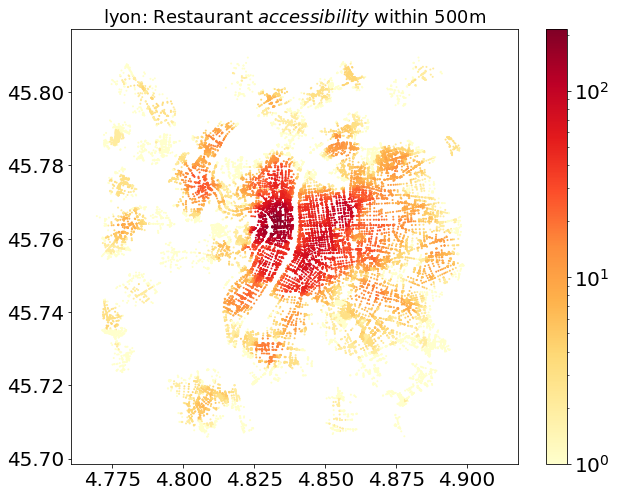

time: 770 ms (started: 2021-08-15 09:50:37 +02:00)


In [49]:
import matplotlib
plt.rcParams.update({'font.size':20})
fig, ax = plt.subplots(figsize=(10,8))

plt.title('lyon: Restaurant $accessibility$ within 500m', size = 18)
plt.scatter(network.nodes_df.x, network.nodes_df.y, 
            c=accessibility, s=1, cmap='YlOrRd', 
            norm=matplotlib.colors.LogNorm())
cb = plt.colorbar()

plt.show()

In [50]:
network_nodes = network.nodes_df
network_nodes.head()

x          y
id                         
126079  4.820423  45.752337
126096  4.783862  45.789279
143356  4.843250  45.714458
143360  4.863275  45.717665
143365  4.893809  45.724187

time: 5.98 ms (started: 2021-08-15 09:50:40 +02:00)


In [51]:
network_nodes["accessibility"] = accessibility
network_nodes.head()

x          y  accessibility
id                                        
126079  4.820423  45.752337            0.0
126096  4.783862  45.789279            0.0
143356  4.843250  45.714458            0.0
143360  4.863275  45.717665            0.0
143365  4.893809  45.724187            0.0

time: 7.63 ms (started: 2021-08-15 09:50:43 +02:00)


In [52]:
# let's create Point geometries from the lat, lon pairs.
geometry = [Point(xy) for xy in zip(network_nodes.x, network_nodes.y)]
network_nodes = network_nodes.drop(['x', 'y'], axis=1)
network_gdf = gpd.GeoDataFrame(network_nodes, crs=crs, geometry=geometry)
network_gdf.head()

accessibility                  geometry
id                                             
126079            0.0  POINT (4.82042 45.75234)
126096            0.0  POINT (4.78386 45.78928)
143356            0.0  POINT (4.84325 45.71446)
143360            0.0  POINT (4.86328 45.71766)
143365            0.0  POINT (4.89381 45.72419)

time: 942 ms (started: 2021-08-15 09:50:45 +02:00)


In [53]:
pointInPoly = gpd.sjoin(polyframe_gps, network_gdf, op='contains')
print(len(pointInPoly))
pointInPoly.head(10)

23181


geometry  population  index_right  \
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...   165.14006   1849618761   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...   165.14006   1849618759   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...   165.14006   1847333006   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...   165.14006   4262902833   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...   165.14006   1385683132   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...   165.14006   3302688255   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...   165.14006      8565540   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...   165.14006   3601912875   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...   165.14006   3601912868   
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...   165.14006   4262864760   

   accessibility  
0            0.0  
0            0.0  
0            0.0  
0            0.0  
0            0.0  
0            0.0  
0            0.0  
0            0.0  
0            0.0  
0            0.0

time: 1.11 s (started: 2021-08-15 09:50:48 +02:00)


In [54]:
aggr_access = pointInPoly.groupby(pointInPoly.index)['accessibility'].mean()
aggr_access_df = pd.DataFrame(aggr_access)
aggr_access_df.columns = ['aggr_access']
aggr_access_df.max()

aggr_access    152.033333
dtype: float64

time: 13.6 ms (started: 2021-08-15 09:51:00 +02:00)


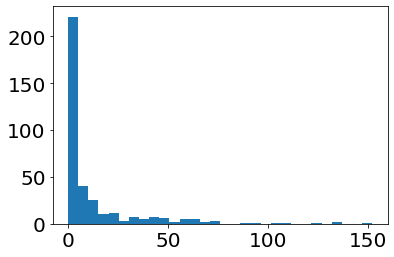

time: 133 ms (started: 2021-08-15 09:51:08 +02:00)


In [55]:
# a quick histogram of the aggregated accessibility
plt.hist(aggr_access_df.aggr_access, bins=30)
plt.show()

In [56]:
polyaccess = polyframe_gps.copy()
polyaccess['aggr_access'] = aggr_access_df.aggr_access
polyaccess['aggr_access'].fillna(0, inplace=True)
#polyaccess['aggr_access'] = polyaccess['aggr_access'].astype(int)
polyaccess

geometry  population  \
0    POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...  165.140060   
1    POLYGON ((4.77535 45.75358, 4.77596 45.75377, ...    0.000000   
2    POLYGON ((4.77684 45.75007, 4.77676 45.74755, ...  426.276093   
3    POLYGON ((4.77697 45.75407, 4.77722 45.75413, ...  553.933533   
4    POLYGON ((4.78201 45.75347, 4.78190 45.75000, ...  381.807251   
..                                                 ...         ...   
382  POLYGON ((4.79199 45.78463, 4.79203 45.78478, ...  505.787277   
383  POLYGON ((4.78818 45.78816, 4.78823 45.78974, ...  525.831970   
384  POLYGON ((4.78812 45.78615, 4.78688 45.78601, ...    0.000000   
385  POLYGON ((4.78515 45.78821, 4.78534 45.78833, ...    0.000000   
386  POLYGON ((4.78210 45.75620, 4.78209 45.75653, ...    0.000000   

     aggr_access  
0       0.000000  
1       0.000000  
2       0.000000  
3       0.000000  
4       0.166667  
..           ...  
382     0.786408  
383     0.041667  
384     0.170732  
385     0.000000  
386     0.000000  

[387 rows x 3 columns]

time: 118 ms (started: 2021-08-15 09:51:21 +02:00)


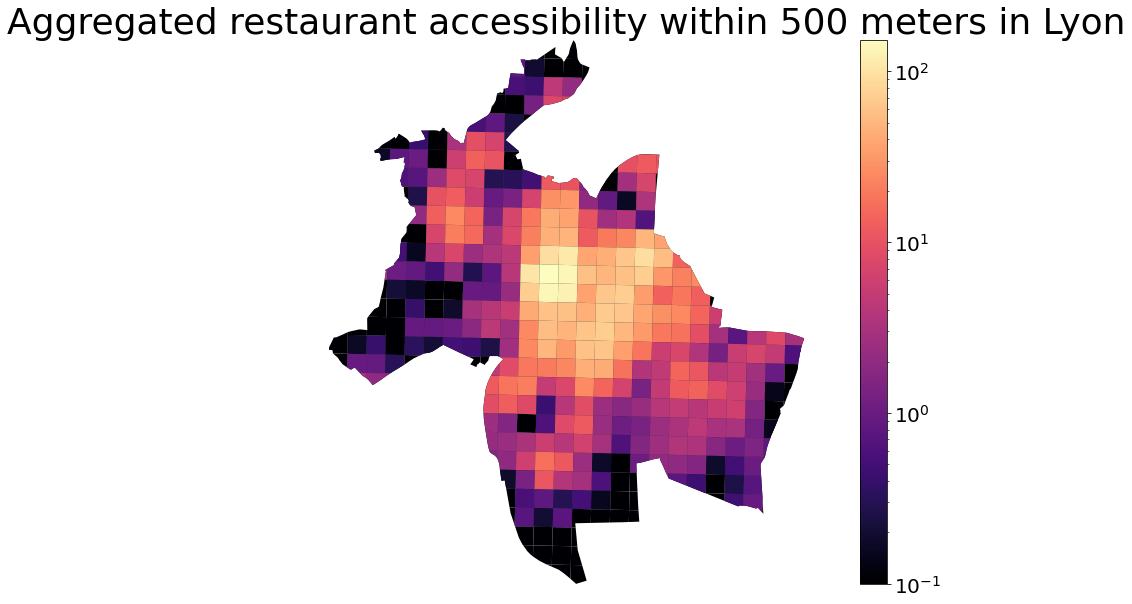

time: 559 ms (started: 2021-08-15 09:51:25 +02:00)


In [57]:
# plot the city aggregated accessibility

LOGMIN = 0.1  # arbitrary lower bound, as appropriate for log-scaled data display
west, south, east, north = polyaccess.unary_union.bounds
fig, ax = plt.subplots(figsize=(20,10))

polyframe_gps.plot(ax=ax, color='#000004')
polyaccess.plot(column='aggr_access',  legend=True, \
    norm=matplotlib.colors.LogNorm(vmin=max(polyaccess.aggr_access.min(), LOGMIN), \
                                   vmax=polyaccess.aggr_access.max()), \
                                    cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
plt.title("Aggregated restaurant accessibility within 500 meters in Lyon", size = 36)
ax.axis('off')
plt.show()

In [58]:
polyaccess["pop_int"] = polyaccess.population.astype(int) + 1
polyaccess.head()

geometry  population  aggr_access  \
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...  165.140060     0.000000   
1  POLYGON ((4.77535 45.75358, 4.77596 45.75377, ...    0.000000     0.000000   
2  POLYGON ((4.77684 45.75007, 4.77676 45.74755, ...  426.276093     0.000000   
3  POLYGON ((4.77697 45.75407, 4.77722 45.75413, ...  553.933533     0.000000   
4  POLYGON ((4.78201 45.75347, 4.78190 45.75000, ...  381.807251     0.166667   

   pop_int  
0      166  
1        1  
2      427  
3      554  
4      382

time: 28 ms (started: 2021-08-15 09:51:38 +02:00)


In [80]:

highest_res = polyaccess['aggr_access'].max()
highest_res_poly = polyaccess[polyaccess['aggr_access'] == highest_res]

time: 19 ms (started: 2021-08-10 09:36:26 +00:00)


In [59]:
polyaccess["access_normalised"] = polyaccess.aggr_access / polyaccess.pop_int 
polyaccess.tail()

geometry  population  \
382  POLYGON ((4.79199 45.78463, 4.79203 45.78478, ...  505.787277   
383  POLYGON ((4.78818 45.78816, 4.78823 45.78974, ...  525.831970   
384  POLYGON ((4.78812 45.78615, 4.78688 45.78601, ...    0.000000   
385  POLYGON ((4.78515 45.78821, 4.78534 45.78833, ...    0.000000   
386  POLYGON ((4.78210 45.75620, 4.78209 45.75653, ...    0.000000   

     aggr_access  pop_int  access_normalised  
382     0.786408      506           0.001554  
383     0.041667      526           0.000079  
384     0.170732        1           0.170732  
385     0.000000        1           0.000000  
386     0.000000        1           0.000000

time: 28.7 ms (started: 2021-08-15 09:53:14 +02:00)


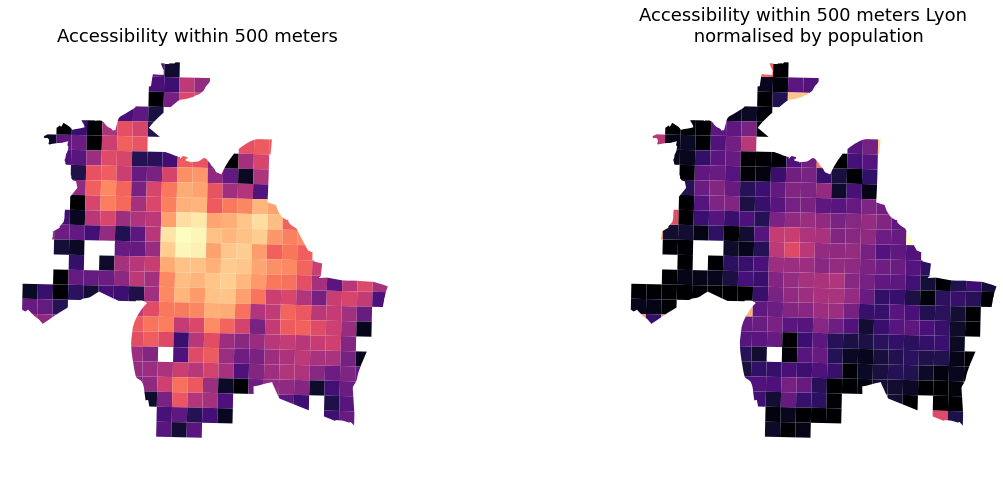

time: 408 ms (started: 2021-08-15 10:18:19 +02:00)


In [103]:
f, ax = plt.subplots(1,2,figsize=(20,8))

polyaccess.plot(column='aggr_access', ax = ax[0], \
    norm=matplotlib.colors.LogNorm(vmin=max(polyaccess.aggr_access.min(), LOGMIN), \
                                   vmax=polyaccess.aggr_access.max()), \
                                    cmap='magma')   
  
ax[0].axis(polyaccess.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Accessibility within 500 meters", size = 18)


polyaccess.plot(column='access_normalised', ax = ax[1], \
    norm=matplotlib.colors.LogNorm(vmin=max(polyaccess.access_normalised.min(), 0.001), \
                                   vmax=polyaccess.access_normalised.max()), \
                                    cmap='magma')

ax[1].axis(polyaccess.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Accessibility within 500 meters Lyon \n normalised by population", size = 18)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [104]:
polyaccess.head()

geometry  population  aggr_access  \
0  POLYGON ((4.77181 45.75103, 4.77188 45.75114, ...  165.140060     0.000000   
1  POLYGON ((4.77535 45.75358, 4.77596 45.75377, ...    0.000000     0.000000   
2  POLYGON ((4.77684 45.75007, 4.77676 45.74755, ...  426.276093     0.000000   
3  POLYGON ((4.77697 45.75407, 4.77722 45.75413, ...  553.933533     0.000000   
4  POLYGON ((4.78201 45.75347, 4.78190 45.75000, ...  381.807251     0.166667   

   pop_int  access_normalised  
0      166           0.000000  
1        1           0.000000  
2      427           0.000000  
3      554           0.000000  
4      382           0.000436

time: 24.5 ms (started: 2021-08-15 10:20:45 +02:00)


In [105]:
polyaccess.aggr_access.min()

0.0

time: 2.21 ms (started: 2021-08-15 10:20:48 +02:00)


In [106]:
polyaccess.aggr_access.max()

152.03333333333333

time: 2.33 ms (started: 2021-08-15 10:20:49 +02:00)


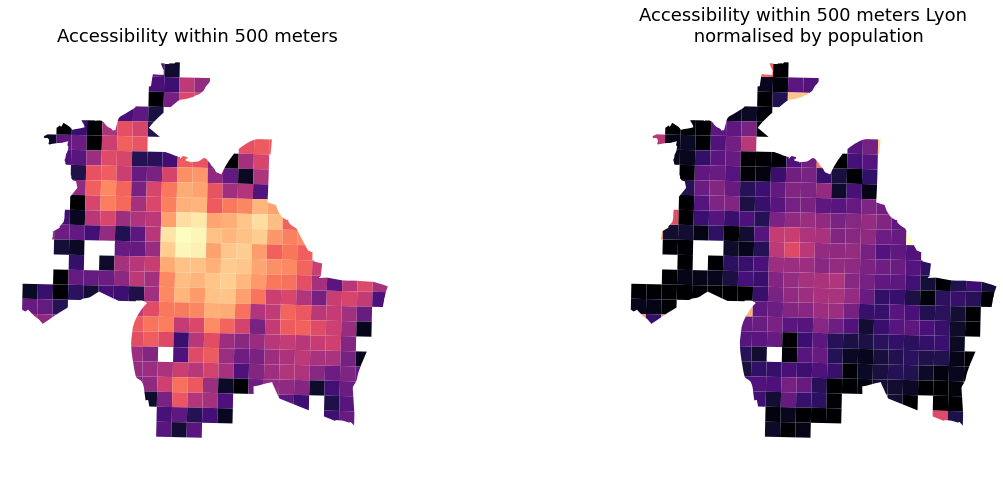

time: 411 ms (started: 2021-08-15 10:23:28 +02:00)


In [114]:
f, ax = plt.subplots(1,2,figsize=(20,8))

polyaccess.plot(column='aggr_access', ax = ax[0], \
    norm=matplotlib.colors.LogNorm(vmin=max(polyaccess.aggr_access.min(), LOGMIN), \
                                   vmax=polyaccess.aggr_access.max()), \
                                    cmap='magma')   
  
ax[0].axis(polyaccess.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Accessibility within 500 meters", size = 18)


polyaccess.plot(column='access_normalised', ax = ax[1], \
    norm=matplotlib.colors.LogNorm(vmin=max(polyaccess.access_normalised.min(), 0.001), \
                                   vmax=polyaccess.access_normalised.max()), \
                                    cmap='magma')

ax[1].axis(polyaccess.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Accessibility within 500 meters Lyon \n normalised by population", size = 18)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [118]:
polyaccess.aggr_access.mean()

11.501621693466701

time: 12.7 ms (started: 2021-08-17 11:54:09 +02:00)


In [126]:
#Final Score
polyaccess.access_normalised.mean()

0.1979947636608183

time: 2.77 ms (started: 2021-08-18 13:25:56 +02:00)


In [115]:
polyaccess.access_normalised.sum()

76.62397353673671

time: 2.67 ms (started: 2021-08-15 10:46:15 +02:00)


In [116]:
sum(polyaccess.access_normalised)

76.62397353673668

time: 77.9 ms (started: 2021-08-16 16:03:50 +02:00)
